In [1]:
%run cv.ipynb

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


0


In [2]:
'''audit_timestamp = train_data.audit_timestamp.apply(lambda x: int(x) // 1000)
plt.figure(figsize=(35,15))
plt.hist(audit_timestamp, 1800, color='red', alpha=0.5, stacked=True)
plt.show()'''

"audit_timestamp = train_data.audit_timestamp.apply(lambda x: int(x) // 1000)\nplt.figure(figsize=(35,15))\nplt.hist(audit_timestamp, 1800, color='red', alpha=0.5, stacked=True)\nplt.show()"

In [3]:
'''plt.figure(figsize=(35,15))
plt.hist(audit_timestamp[(audit_timestamp % (3600*24) > 7*3600) & (audit_timestamp % (3600*24) < 20*3600)], 1800, color='red', alpha=0.5, stacked=True)
plt.show()'''

"plt.figure(figsize=(35,15))\nplt.hist(audit_timestamp[(audit_timestamp % (3600*24) > 7*3600) & (audit_timestamp % (3600*24) < 20*3600)], 1800, color='red', alpha=0.5, stacked=True)\nplt.show()"

In [4]:
train_texts_features = pd.read_pickle(output_path + '/train_text_features8')
test_texts_features = pd.read_pickle(output_path + '/test_text_features8')

In [5]:
train_texts_features['embedding'] = pd.read_pickle(output_path + '/train_15_svd').embeddings
test_texts_features['embedding'] = pd.read_pickle(output_path + '/test_15_svd').embeddings



In [6]:
assigned_clusters3_15 = pd.read_pickle(output_path + '/assigned_clusters3_15').assigned_clusters3_15
train_texts_features['assigned_clusters'] = assigned_clusters3_15[0:train_texts_features.shape[0]]

In [7]:
train_data = pd.read_pickle(output_path + '/train_data')
test_data = pd.read_pickle(output_path + '/test_data')

In [8]:
stat = pd.concat((train_data, test_data), sort=False)[['metadata_ownerId', 'objectId']] \
    .groupby('metadata_ownerId').agg({'objectId': 'count'})
stat.rename(columns={'objectId': 'owner_count'}, inplace=True)

In [9]:
#stat2 = pd.concat((train_data, test_data), sort=False)[['objectId', 'instanceId_userId']] \
#    .groupby('objectId').agg({'instanceId_userId': 'count'})
#stat2.rename(columns={'instanceId_userId': 'object_count'}, inplace=True)

In [10]:
train_data = train_data.join(stat, how='left', on='metadata_ownerId')
#train_data = train_data.join(stat2, how='left', on='metadata_ownerId')
train_data = train_data.join(train_texts_features.set_index('objectId'), how='inner', on='objectId')

In [11]:
test_data = test_data.join(stat, how='left', on='metadata_ownerId')
#test_data = test_data.join(stat2, how='left', on='metadata_ownerId')
test_data = test_data.join(test_texts_features.set_index('objectId'), how='inner', on='objectId')

In [12]:
def is_day(ts):
    ts = int(ts) // 1000
    x = ts % 3600*24
    return x > 7*3600 and x < 20*3600

train_data['is_day'] = train_data.metadata_createdAt.apply(is_day)

In [13]:
#lang_stat = train_data[['lang', 'liked']] \
#    .groupby('lang').mean()
#lang_stat.rename(columns={'liked': 'mean_target'}, inplace=True)

In [14]:
#train_data = train_data.join(lang_stat, how='left', on='lang')
#test_data = test_data.join(lang_stat, how='left', on='lang')

In [15]:
def predict_to_submit(X, proba):
    X = X.assign(weight=-proba)
    scores = X[['instanceId_userId', 'objectId', 'weight']] \
            .groupby(['instanceId_userId','objectId']).mean()
    result = scores.sort_values(by=['instanceId_userId', 'weight']).reset_index()
    # Collect predictions for each user
    submit = result.groupby("instanceId_userId")['objectId'].apply(list)
    return submit

class SimpleModel(MyModel):
    def get_X(self, data):
        X = data.drop(['objectId', 'instanceId_userId'], 1)
        if 'label' in data.columns:
            X.drop('label', 1, inplace=True)
        return X
    def fit(self, data):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.scaler = StandardScaler()
            X = self.get_X(data)
            self.scaler.fit(X)
            X = self.scaler.transform(X)
            y = data['label'].values
            #self.model = LogisticRegression(random_state=123, solver='lbfgs').fit(X, y)
            params = self.params
            self.model = MLPClassifier(alpha=params['alpha'], hidden_layer_sizes=params['hidden_layer_sizes'],
                                       max_iter=params['max_iter'], learning_rate_init=params['learning_rate_init'],
                                       activation=params['activation'],
                                       random_state=params['random_state']).fit(X, y)
    def predict(self, X):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X = self.scaler.transform(self.get_X(X))
            proba_result = self.model.predict_proba(X)
            return proba_result[:, 1]
    
class LgbModel(SimpleModel):
    def fit(self, data):
        lgb_train = lgb.Dataset(self.get_X(data), data['label'].values)
        categorical_feature=['assigned_clusters']
        
        #if self.verbose >= 2:
        print('Starting train: %s' % datetime.datetime.now())
        params = self.params.copy()
        num_boost_round = params['num_boost_round']
        del params['num_boost_round']
        #params['objective'] = 'binary'
        params['metric'] = 'auc'
        self.model = lgb.train(
            params,
            lgb_train,
            num_boost_round=num_boost_round
        )
    def predict(self, X):
        proba = self.model.predict(self.get_X(X))
        return proba


In [16]:
def feat(x):
    n = x.shape[0]
    return np.add.reduce(x.embedding.values) / n

def create_features(data):
    ones = np.repeat(1, data.shape[0])
    res = pd.DataFrame({
        'instanceId_userId': data['instanceId_userId'],
        'objectId': data['objectId'],
        'object_type': data['instanceId_objectType'],
        'client_type': data['audit_clientType'],
        'len': data['len'],
        'p_len': data['p_len'],
        #'plen_per_len': data['p_len'] / data['len'],
        'q_count': data['q_count'],
        'links_count': data['links_count'],
        'emojis_rate': data['emojis_count'] / data['len'],
        'upper_rate': data['upper_count'] / data['len'],
        'ok_videos_count': data['ok_videos_count'].clip(upper=1),
        'ok_groups_count': data['ok_groups_count'].clip(upper=1),
        'youtube_count': data['youtube_count'].clip(upper=1),
        #'is_video': (data['youtube_count'] + data['ok_videos_count']).clip(upper=1),
        'is_adv': data['is_adv'],
        'is_recipe': data['is_recipe'],
        'brackets_balance': data['brackets_balance'],
        'quotes_count': data['quotes_count'],
        'mdots_count': data['mdots_count'],
        'e_count': data['e_count'],
        #'assigned_clusters': data['assigned_clusters'],
        'owner_count': data['owner_count'],
        'old': data['audit_timestamp'] - data['metadata_createdAt'],
        #'mean_target': data['mean_target'],
        'has_phone': data['has_phone'],                                     #sm+
        #'hashes_count': data['hashes_count'],
        #'is_ru': data['lang'] == 'ru',
        #'is_day': data['is_day'],
        'has_newline': data['lines_count'].clip(upper=1),                   #sm+
        #'object_count': data['object_count'],
        #'end': data['e_end'] | data['q_end'] | data['d_end'],
        #'md_count': data['md_count'].clip(upper=1),
    })
    #qq = data[['instanceId_userId', 'embedding']].join(
    #        data.groupby('instanceId_userId').apply(feat).reset_index().set_index('instanceId_userId'), 
    #        on='instanceId_userId')
    #print('Cosing:')
    #res['emb_dist'] = (qq.iloc[:,1] - qq.iloc[:,2]).apply(np.linalg.norm)
    #res['emb_cosine_dist'] = qq.iloc[:,1:3].apply(lambda x: scipy.spatial.distance.cosine(*x), axis=1)
    #print('Embs:')
    
    emb = np.stack(data['embedding'])
    for j in range(emb.shape[1]):
        res['emb%d' % j] = emb[:,j]

    if 'liked' in data.columns:
        res['label'] = data['liked']
            
    return res

In [17]:
%%time
train = create_features(train_data.head(10000))

CPU times: user 35.5 ms, sys: 44.9 ms, total: 80.3 ms
Wall time: 135 ms


In [18]:
train.columns

Index(['instanceId_userId', 'objectId', 'object_type', 'client_type', 'len',
       'p_len', 'q_count', 'links_count', 'emojis_rate', 'upper_rate',
       'ok_videos_count', 'ok_groups_count', 'youtube_count', 'is_adv',
       'is_recipe', 'brackets_balance', 'quotes_count', 'mdots_count',
       'e_count', 'owner_count', 'old', 'has_phone', 'has_newline', 'emb0',
       'emb1', 'emb2', 'emb3', 'emb4', 'emb5', 'emb6', 'emb7', 'emb8', 'emb9',
       'emb10', 'emb11', 'emb12', 'emb13', 'emb14', 'label'],
      dtype='object')

In [19]:
%%time
train = create_features(train_data)

CPU times: user 36.9 s, sys: 11.6 s, total: 48.5 s
Wall time: 52.3 s


In [ ]:
cross_validation(SimpleModel({
    'activation': 'relu',
    'alpha': 0.0002, 
    'hidden_layer_sizes': (20,10),
    'max_iter': 150,
    'learning_rate_init': 0.001,
    'random_state': 322,
}), train[train.instanceId_userId % 4 == 0], n_iters=1, verbose=2)
#0 - 1 : 0.6302, mean=0.6302
#0 - 2 : 0.6340, mean=0.6321
#0 - 3 : 0.6336, mean=0.6326
#0 - 4 : 0.6349, mean=0.6332
#0 - 5 : 0.6355, mean=0.6336

In [ ]:
cross_validation(SimpleModel({
    'activation': 'relu',
    'alpha': 0.0002, 
    'hidden_layer_sizes': (20,10),
    'max_iter': 150,
    'learning_rate_init': 0.001,
    'random_state': 322,
}), train, n_iters=1, verbose=2)
#0 - 1 : 0.6343, mean=0.6343
#0 - 2 : 0.6350, mean=0.6347
#0 - 3 : 0.6336, mean=0.6343
#0 - 4 : 0.6362, mean=0.6348
#0 - 5 : 0.6335, mean=0.6345

In [140]:
cross_validation(MeanModel([SimpleModel({
    'activation': 'relu',
    'alpha': 0.0002, 
    'hidden_layer_sizes': (20,10),
    'max_iter': 150,
    'learning_rate_init': 0.001,
    'random_state': 322,
}), LgbModel({
    #'num_threads': 4,
    #'objective': 'binary',
    'boosting_type': 'gbdt',
    'min_data_in_leaf': min_data_in_leaf,
    'lambda_l2': lambda_l2,
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,
    'feature_fraction': feature_fraction,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'num_boost_round': num_boost_round,
    #'max_depth': 4,
    'verbose': 0
})], [0.2, 0.8]), train[train.instanceId_userId % 4 == 0], n_iters=1, verbose=2)

KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-03 12:55:49.726751
Fit: 2019-03-03 12:55:53.899066
Starting train: 2019-03-03 13:00:23.640107
Predict: 2019-03-03 13:02:31.636356
Auc: 2019-03-03 13:02:43.630157
 0 - 1 : 0.6428, mean=0.6428
Prepare data: 2019-03-03 13:02:43.869736
Fit: 2019-03-03 13:02:48.432884
Starting train: 2019-03-03 13:06:03.138844
Predict: 2019-03-03 13:07:56.479731
Auc: 2019-03-03 13:08:07.760857
 0 - 2 : 0.6485, mean=0.6457
Prepare data: 2019-03-03 13:08:08.008444
Fit: 2019-03-03 13:08:11.709497
Starting train: 2019-03-03 13:12:29.351229
Predict: 2019-03-03 13:14:32.795332
Auc: 2019-03-03 13:14:44.816287
 0 - 3 : 0.6465, mean=0.6460
Prepare data: 2019-03-03 13:14:45.087854
Fit: 2019-03-03 13:14:50.995079
Starting train: 2019-03-03 13:19:37.795959
Predict: 2019-03-03 13:21:48.386645
Auc: 2019-03-03 13:21:59.751583
 0 - 4 : 0.6469, mean=0.6462
Prepare data: 2019-03-03 13:21:59.997758
Fit: 2019-03-03 13:22:04.246438
Starting train: 2019-03-

In [141]:
cross_validation(MeanModel([SimpleModel({
    'activation': 'relu',
    'alpha': 0.0002, 
    'hidden_layer_sizes': (20,10),
    'max_iter': 150,
    'learning_rate_init': 0.001,
    'random_state': 322,
}), LgbModel({
    #'num_threads': 4,
    #'objective': 'binary',
    'boosting_type': 'gbdt',
    'min_data_in_leaf': min_data_in_leaf,
    'lambda_l2': lambda_l2,
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,
    'feature_fraction': feature_fraction,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'num_boost_round': num_boost_round,
    #'max_depth': 4,
    'verbose': 0
})], [0.2, 0.8]), train, n_iters=1, verbose=2)

KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-03 13:37:44.297815
Fit: 2019-03-03 13:38:15.259374
Starting train: 2019-03-03 13:54:29.038383
Predict: 2019-03-03 14:02:46.777934
Auc: 2019-03-03 14:03:33.764797
 0 - 1 : 0.6546, mean=0.6546
Prepare data: 2019-03-03 14:03:34.858943
Fit: 2019-03-03 14:04:05.008568
Starting train: 2019-03-03 14:21:08.876929
Predict: 2019-03-03 14:29:55.398157
Auc: 2019-03-03 14:30:40.288930
 0 - 2 : 0.6551, mean=0.6549
Prepare data: 2019-03-03 14:30:41.454805
Fit: 2019-03-03 14:31:11.550560
Starting train: 2019-03-03 14:46:05.297896
Predict: 2019-03-03 14:54:45.267508
Auc: 2019-03-03 14:55:32.654440
 0 - 3 : 0.6540, mean=0.6546
Prepare data: 2019-03-03 14:55:33.804110


KeyboardInterrupt: 

In [20]:
%%time
#################################### PARTIAL TRAIN
for min_data_in_leaf in (20,):
    for lambda_l2 in (0.0,):
        for learning_rate in (0.35,):
            for feature_fraction in (1,):
                for num_boost_round in (1000,):
                    for num_leaves in (30,):
                        print((min_data_in_leaf,lambda_l2,learning_rate,feature_fraction,num_boost_round,num_leaves))
                        cross_validation(LgbModel({
                            #'num_threads': 4,
                            #'objective': 'binary',
                            'boosting_type': 'gbdt',
                            'min_data_in_leaf': min_data_in_leaf,
                            'lambda_l2': lambda_l2,
                            'num_leaves': num_leaves,
                            'learning_rate': learning_rate,
                            'feature_fraction': feature_fraction,
                            'bagging_fraction': 1,
                            'bagging_freq': 5,
                            'num_boost_round': num_boost_round,
                            #'max_depth': 4,
                            'verbose': 0
                        }), train[train.instanceId_userId % 4 == 0], n_iters=1, verbose=2)

(20, 0.0, 0.35, 1, 1000, 30)
KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-03 16:31:11.163346
Fit: 2019-03-03 16:31:15.845107
Starting train: 2019-03-03 16:31:19.297519
Predict: 2019-03-03 16:33:14.603378
Auc: 2019-03-03 16:33:23.861243
 0 - 1 : 0.6462, mean=0.6462
Prepare data: 2019-03-03 16:33:24.082721
Fit: 2019-03-03 16:33:27.780455
Starting train: 2019-03-03 16:33:29.794971
Predict: 2019-03-03 16:35:31.807262
Auc: 2019-03-03 16:35:41.892431
 0 - 2 : 0.6504, mean=0.6483
Prepare data: 2019-03-03 16:35:42.154536
Fit: 2019-03-03 16:35:46.290673
Starting train: 2019-03-03 16:35:47.845431
Predict: 2019-03-03 16:37:59.102541
Auc: 2019-03-03 16:38:08.910195
 0 - 3 : 0.6501, mean=0.6489
Prepare data: 2019-03-03 16:38:09.183181
Fit: 2019-03-03 16:38:13.407979
Starting train: 2019-03-03 16:38:15.234419
Predict: 2019-03-03 16:40:27.671673
Auc: 2019-03-03 16:40:37.410450
 0 - 4 : 0.6486, mean=0.6488
Prepare data: 2019-03-03 16:40:37.676335
Fit: 2019-03-03 16:40:41.74

In [25]:
%%time
for min_data_in_leaf in (20,):
    for lambda_l2 in (0.0,):
        for learning_rate in (0.35,):
            for feature_fraction in (1,):
                for num_boost_round in (1000,):
                    for num_leaves in (30,):
                        print((min_data_in_leaf,lambda_l2,learning_rate,feature_fraction,num_boost_round,num_leaves))
                        cross_validation(LgbModel({
                            'boosting_type': 'gbdt',
                            'min_data_in_leaf': min_data_in_leaf,
                            'lambda_l2': lambda_l2,
                            'num_leaves': num_leaves,
                            'learning_rate': learning_rate,
                            'feature_fraction': feature_fraction,
                            'bagging_fraction': 1,
                            'bagging_freq': 5,
                            'num_boost_round': num_boost_round,
                            #'max_depth': 4,
                            'verbose': 0
                        }), train, n_iters=1, verbose=2)

(20, 0.0, 0.35, 1, 1000, 35)
KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-03 17:58:08.421300
Fit: 2019-03-03 17:58:40.235589
Starting train: 2019-03-03 17:59:05.497950
Predict: 2019-03-03 18:07:53.098323
Auc: 2019-03-03 18:08:36.146469
 0 - 1 : 0.6591, mean=0.6591
Prepare data: 2019-03-03 18:08:37.210335


KeyboardInterrupt: 

In [126]:
cross_validation(SimpleModel({
    'activation': 'relu',
    'alpha': 0.0002, 
    'hidden_layer_sizes': (30,15),
    'max_iter': 150,
    'learning_rate_init': 0.001,
    'random_state': 322,
}), train, n_iters=1, verbose=2)

KFold(n_splits=5, random_state=2707, shuffle=True)
Prepare data: 2019-03-03 12:20:16.209874
Fit: 2019-03-03 12:20:49.620798


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int8, int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int8, int64, float32, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Predict: 2019-03-03 12:23:28.459235


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-126-e5ee90825de5>", line 8, in <module>
    }), train, n_iters=1, verbose=2)
  File "<ipython-input-103-b43944772e3d>", line 20, in cross_validation
    pred = model.predict(data_test.drop('label', 1))
  File "/usr/local/lib/python3.7/site-packages/pandas/core/frame.py", line 3940, in drop
    errors=errors)
  File "/usr/local/lib/python3.7/site-packages/pandas/core/generic.py", line 3780, in drop
    obj = obj._drop_axis(labels, axis, level=level, errors=errors)
  File "/usr/local/lib/python3.7/site-packages/pandas/core/generic.py", line 3813, in _drop_axis
    result = self.reindex(**{axis_name: new_axis})
  File "/usr/local/lib/python3.7/site-packages/pandas/util/_decorators.py", line 197, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/site


KeyboardInterrupt



In [43]:
np.concatenate((train.instanceId_userId.values, test.instanceId_userId.values))

array([    1618,     2122,   405739, ..., 15717307, 15717313, 15717370],
      dtype=int32)

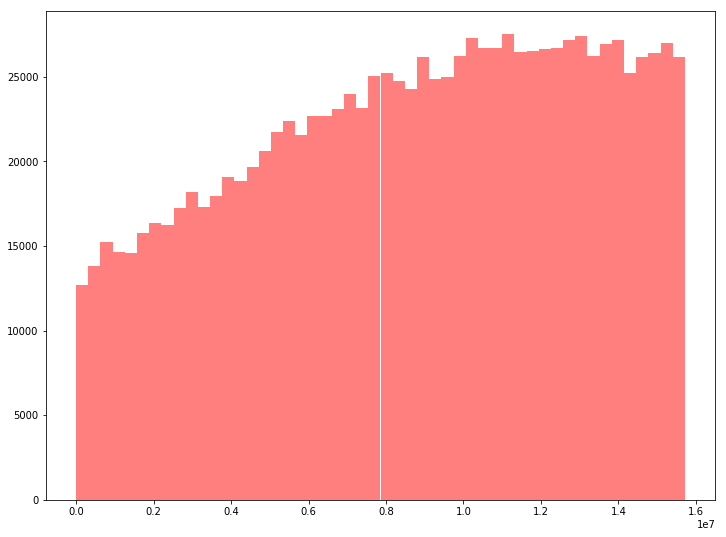

In [47]:
plt.figure()
#plt.hist(train.instanceId_userId.values, 50, color='blue', alpha=0.5, stacked=True)
plt.hist(test.instanceId_userId.values, 50, color='red', alpha=0.5, stacked=True)
plt.show()

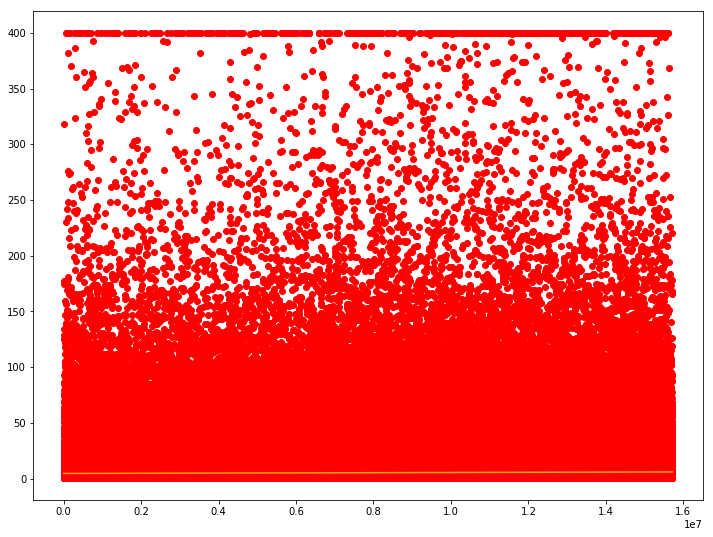

In [65]:
plt.rcParams["figure.figsize"] = (12, 9) # (w, h)
stat = train.groupby('instanceId_userId').agg({'objectId': 'count'}).reset_index()
stat['objectId'].clip(upper=400, inplace=True)
x = stat.instanceId_userId.values
y = stat.objectId.values
plt.plot(stat.instanceId_userId.values, stat.objectId.values, marker='o', color='r', ls='')
a, b = np.polyfit(x, y, deg=1)
f = lambda x: a*x + b
plt.plot([min(x), max(x)],[f(min(x)), f(max(x))], c="orange", label="---")
plt.show()

In [66]:
[min(x), max(x)],[f(min(x)), f(max(x))]

([1, 15716692], [4.675623173024054, 6.05310121218764])

In [87]:
train_texts_features.embedding

0          [-0.10615078, -0.010773562, -0.56575644, -0.12...
1          [-0.0683545, 0.07140685, -0.20106804, 0.104985...
2          [-0.02723738, 0.06277889, -0.43565413, 0.18430...
3          [0.045580994, 0.040244624, -0.6059874, 0.25647...
4          [0.0032542336, 0.014345958, 0.0068508917, 0.00...
5          [-0.08434731, 0.44924405, -0.11457637, 0.18142...
6          [0.054944713, -0.016345793, -0.20541555, 0.053...
7          [0.058710147, -0.04227986, -0.21007676, 0.0421...
8          [-0.007924212, 0.023569267, -0.40307418, 0.166...
9          [0.0017259811, -0.04990819, -0.4736356, 0.1148...
10         [-0.09405366, 0.13276497, -0.51096237, 0.12392...
11         [0.07896449, -0.015920404, -0.2127133, 0.10028...
12         [-0.72267175, 0.2736861, -0.6084051, -0.400014...
13         [-0.037868008, 0.30197683, -0.45972252, 0.3364...
14         [0.0309244, 0.04448738, -0.21612203, 0.0947049...
15         [-0.019892128, 0.058245588, -0.3105936, 0.0849...
16         [0.0032542336

In [103]:
kclusterer = KMeansClusterer(3, distance=nltk.cluster.util.cosine_distance, repeats=50)
assigned_clusters3_50 = kclusterer.cluster(
    np.concatenate((train_texts_features.embedding, test_texts_features.embedding)), assign_clusters=True)

In [75]:
kclusterer = KMeansClusterer(6, distance=nltk.cluster.util.cosine_distance, repeats=25, avoid_empty_clusters=True)
assigned_clusters6_25 = kclusterer.cluster(
    np.concatenate((train_texts_features.embedding, test_texts_features.embedding)), assign_clusters=True)

3

In [76]:
train_texts_features['assigned_clusters'] = assigned_clusters6_25[0:train_texts_features.shape[0]]

In [124]:
pd.DataFrame({'assigned_clusters3_50': assigned_clusters3_50}).to_pickle(output_path + '/assigned_clusters3_50')

In [7]:
train_data.head(200)

,instanceId_userId,instanceId_objectType,objectId,audit_clientType,audit_timestamp,metadata_ownerId,metadata_createdAt,date,liked,clicked,...,ok_groups_count,is_adv,is_recipe,hashes_count,quotes_count,mdots_count,brackets_balance,has_phone,is_poll,e_count
0,1618,0,25814780,0,1517458217938,81088,1517454825000,2018-02-01,0,1,...,0,0,0,0,0,0,0,0,False,1
1,2122,0,10027037,1,1517488844356,4016,1517423778000,2018-02-01,0,0,...,0,0,1,0,0,0,9,0,False,1
1070,405739,0,10027037,2,1517511247948,4016,1517423778000,2018-02-01,0,0,...,0,0,1,0,0,0,9,0,False,1
1759,659725,0,10027037,0,1517466559543,4016,1517423778000,2018-02-01,0,0,...,0,0,1,0,0,0,9,0,False,1
4836,1748401,0,10027037,1,1517511622831,4016,1517423778000,2018-02-01,0,0,...,0,0,1,0,0,0,9,0,False,1
6826,2404081,0,10027037,1,1517487632489,4016,1517423778000,2018-02-01,0,0,...,0,0,1,0,0,0,9,0,False,1
8062,2796664,0,10027037,0,1517452044806,4016,1517423778000,2018-02-01,0,1,...,0,0,1,0,0,0,9,0,False,1
12652,4257952,0,10027037,1,1517433315078,4016,1517423778000,2018-02-01,0,0,...,0,0,1,0,0,0,9,0,False,1
18474,6000712,0,10027037,2,1517459635654,4016,1517423778000,2018-02-01,1,0,...,0,0,1,0,0,0,9,0,False,1
19276,6265702,0,10027037,1,1517509974847,4016,1517423778000,2018-02-01,0,1,...,0,0,1,0,0,0,9,0,False,1


In [18]:
stat = train_data[['metadata_ownerId', 'objectId']].groupby('metadata_ownerId').agg({'objectId': 'count'})
stat.rename(columns={'objectId': 'owner_count'}, inplace=True)

In [25]:
train_data = train_data.join(stat, how='left', on='metadata_ownerId')

In [24]:
train_data.shape

(21620659, 34)

In [12]:
train_data[train_data.metadata_ownerId == 1830]

,instanceId_userId,instanceId_objectType,objectId,audit_clientType,audit_timestamp,metadata_ownerId,metadata_createdAt,date,liked,clicked,...,ok_groups_count,is_adv,is_recipe,hashes_count,quotes_count,mdots_count,brackets_balance,has_phone,is_poll,e_count
1294,478603,1,381695,0,1517512856332,1830,1517427680000,2018-02-01,0,0,...,0,0,0,0,0,0,0,0,False,0
272194,1812589,1,381695,0,1517447466017,1830,1517427680000,2018-02-01,0,0,...,0,0,0,0,0,0,0,0,False,0
2648,964096,0,12495694,0,1517433540693,1830,1517297738000,2018-02-01,0,0,...,0,0,0,0,0,0,0,0,False,0
9060,3132628,0,12664249,0,1517501241780,1830,1517484920000,2018-02-01,0,0,...,0,0,0,0,0,0,0,0,False,0
10252,3494800,0,12644535,1,1517466187433,1830,1517464428000,2018-02-01,1,0,...,0,0,0,0,0,0,0,0,False,0
24909,7832953,0,12631622,0,1517492263803,1830,1517437550000,2018-02-01,0,0,...,0,0,0,0,0,0,0,0,False,1
28455,8805769,0,12585382,1,1517458019262,1830,1517396801000,2018-02-01,1,0,...,0,0,0,0,0,0,0,0,False,0
31713,9632917,0,12680535,0,1517500744079,1830,1517498801000,2018-02-01,0,0,...,0,0,0,0,0,0,0,0,False,0
223101,3268288,0,12680535,0,1517499993369,1830,1517498801000,2018-02-01,1,0,...,0,0,0,0,0,0,0,0,False,0
31714,9632917,0,12680205,0,1517500744079,1830,1517498548000,2018-02-01,0,0,...,0,0,0,0,0,0,0,0,False,0


In [34]:
test

,instanceId_userId,objectId,object_type,client_type,len,p_len,q_count,links_count,emojis_rate,upper_rate,...,emb5,emb6,emb7,emb8,emb9,emb10,emb11,emb12,emb13,emb14
0,1006,34577503,0,2,815,67,0,0,0.000000,0.036810,...,0.454263,0.178472,0.693837,0.237298,-0.080836,0.579146,0.070088,-0.507265,-0.483220,-0.376121
162269,1353970,34577503,0,0,815,67,0,0,0.000000,0.036810,...,0.454263,0.178472,0.693837,0.237298,-0.080836,0.579146,0.070088,-0.507265,-0.483220,-0.376121
181608,4032460,34577503,0,0,815,67,0,0,0.000000,0.036810,...,0.454263,0.178472,0.693837,0.237298,-0.080836,0.579146,0.070088,-0.507265,-0.483220,-0.376121
252355,10993288,34577503,0,0,815,67,0,0,0.000000,0.036810,...,0.454263,0.178472,0.693837,0.237298,-0.080836,0.579146,0.070088,-0.507265,-0.483220,-0.376121
257103,11380597,34577503,0,1,815,67,0,0,0.000000,0.036810,...,0.454263,0.178472,0.693837,0.237298,-0.080836,0.579146,0.070088,-0.507265,-0.483220,-0.376121
1,1006,37520199,0,0,29,3,0,0,0.000000,0.034483,...,0.086311,-0.015257,0.078355,0.108342,-0.027261,0.062947,-0.011973,-0.013166,-0.119178,-0.035937
195723,5626507,37520199,0,1,29,3,0,0,0.000000,0.034483,...,0.086311,-0.015257,0.078355,0.108342,-0.027261,0.062947,-0.011973,-0.013166,-0.119178,-0.035937
828593,7873873,37520199,0,0,29,3,0,0,0.000000,0.034483,...,0.086311,-0.015257,0.078355,0.108342,-0.027261,0.062947,-0.011973,-0.013166,-0.119178,-0.035937
988311,8346955,37520199,0,1,29,3,0,0,0.000000,0.034483,...,0.086311,-0.015257,0.078355,0.108342,-0.027261,0.062947,-0.011973,-0.013166,-0.119178,-0.035937
2,1618,546086,1,0,45,6,0,0,0.000000,0.733333,...,0.216033,-0.096391,0.114180,0.203389,0.036926,0.181370,-0.109647,-0.186538,-0.201193,-0.139900


In [22]:
test = create_features(test_data)

In [23]:
model = LgbModel({
    'boosting_type': 'gbdt',
    'min_data_in_leaf': 5,
    'lambda_l2': 0.0,
    'num_leaves': 30,
    'learning_rate': 0.35,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'num_boost_round': 1000,
    'verbose': 0
})
model.fit(train)
pred = model.predict(test)

Starting train: 2019-03-03 17:44:43.571656


In [24]:
submit = predict_to_submit(test, pred)
submit.to_csv(output_path + "/textSubmit1.csv.gz", header=False, compression='gzip')

In [23]:
submit_wtf = submit

In [38]:
len(test.instanceId_userId.unique())

208346

In [33]:
submit.tail(30)

instanceId_userId
15716707                       [16009891, 32563018, 37223481]
15716716                       [37981846, 30362819, 13824432]
15716737                                 [10581360, 10771343]
15716755                                 [36327133, 36636691]
15716767                       [28567915, 28721208, 25916171]
15716776                                 [34910793, 37128958]
15716794    [35910357, 16488728, 17651503, 31555930, 6784871]
15716830                                 [35340349, 36218539]
15716848                       [28426560, 24384653, 31853814]
15716941    [13117605, 37068417, 19578057, 27198417, 30215...
15716959             [34816567, 36265245, 20923848, 19232240]
15716977                                 [37094474, 37962999]
15716983             [35331068, 37536127, 20947325, 21705434]
15716992                       [23365607, 27951107, 23666803]
15717064                        [38281638, 21906388, 7294610]
15717076                        [36615705, 36624949,

In [34]:
submit_wtf.tail(30)

instanceId_userId
15716707                       [16009891, 32563018, 37223481]
15716716                       [37981846, 30362819, 13824432]
15716737                                 [10581360, 10771343]
15716755                                 [36327133, 36636691]
15716767                       [28567915, 28721208, 25916171]
15716776                                 [34910793, 37128958]
15716794    [16488728, 35910357, 6784871, 17651503, 31555930]
15716830                                 [35340349, 36218539]
15716848                       [28426560, 24384653, 31853814]
15716941    [19578057, 30215216, 37068417, 27198417, 23581...
15716959             [34816567, 36265245, 19232240, 20923848]
15716977                                 [37094474, 37962999]
15716983             [35331068, 37536127, 20947325, 21705434]
15716992                       [23365607, 27951107, 23666803]
15717064                        [21906388, 38281638, 7294610]
15717076                        [36624949, 9456063, 

In [39]:
pd.DataFrame({'imp': model.model.feature_importance(), 'col': model.model.feature_name(), 'imp_gain': model.model.feature_importance('gain')})

,imp,col,imp_gain
0,241,object_type,32619.574705
1,697,client_type,12602.484914
2,1124,len,41531.502752
3,533,p_len,4276.300799
4,422,q_count,11239.521965
5,326,links_count,15338.958545
6,499,emojis_rate,2098.395818
7,1335,upper_rate,11498.475846
8,132,ok_videos_count,7816.615267
9,136,ok_groups_count,3430.989628


In [54]:
qm = train.groupby('instanceId_userId')['label'].mean()
qc = train.groupby('instanceId_userId')['label'].count()

In [63]:
((qc == 1)).sum()

1225275

In [81]:
((qc > 143) & (qm == 1)).sum()

1

In [84]:
np.where((qc > 143) & (qm == 1))

(array([2204072]),)

In [93]:
kk=train.groupby('instanceId_userId').groups.keys()

In [98]:
np.fromiter(kk, dtype=np.int32)[2204072]

8901307

In [101]:
train.groupby(['instanceId_userId', 'objectId'])['label'].mean().unique()

array([0.        , 1.        , 0.5       , 0.33333333, 0.25      ])

In [99]:
train[train.instanceId_userId == 8901307]

,instanceId_userId,objectId,object_type,client_type,len,p_len,q_count,links_count,emojis_rate,upper_rate,...,emb6,emb7,emb8,emb9,emb10,emb11,emb12,emb13,emb14,label
15460161,8901307,24762087,0,0,10255,1068,0,3,0.000000,0.044564,...,0.610318,-0.436574,2.509931,-0.718349,2.252410,-1.281812,-0.661460,0.210022,-3.015670,1
15460161,8901307,24762087,0,0,18600,1857,14,14,0.000000,0.046452,...,0.429059,-0.549600,2.258563,-0.730110,2.292785,-1.252876,-0.843268,0.270707,-3.226623,1
15460161,8901307,24762087,0,0,39715,3852,38,34,0.000076,0.047740,...,0.473433,-0.847690,2.538513,-0.151877,2.301774,-0.664430,-1.133903,0.155235,-3.279389,1
15460161,8901307,24762087,0,0,4860,519,0,1,0.000000,0.044650,...,0.489773,-0.182201,2.049111,-0.439966,1.910270,-0.874146,-0.324842,-0.107755,-2.437495,1
15460161,8901307,24762087,0,0,15822,1593,10,10,0.000000,0.046518,...,0.402950,-0.412710,2.391196,-0.612923,2.275326,-1.137810,-0.773451,0.232835,-2.984397,1
15460161,8901307,24762087,0,0,9650,914,10,9,0.000311,0.047150,...,-0.028046,-0.840188,2.441560,0.150805,2.237000,-0.718923,-0.749627,-0.171446,-2.576663,1
15460161,8901307,24762087,0,0,17780,1725,16,13,0.000169,0.045613,...,0.280597,-0.748287,2.630953,0.175076,2.238045,-0.603223,-0.893469,0.174692,-3.054140,1
15460161,8901307,24762087,0,0,32403,3134,34,26,0.000093,0.046045,...,0.431339,-0.782976,2.632773,0.038132,2.151438,-0.607845,-1.061067,0.146258,-3.347508,1
15460161,8901307,24762087,0,0,1804,146,2,5,0.000000,0.075388,...,-0.225446,0.100269,0.567328,0.172970,1.053115,0.191592,-0.388625,-0.704970,-0.400453,1
15460161,8901307,24762087,0,0,51259,5023,41,39,0.000059,0.046626,...,0.505973,-0.882219,2.662633,-0.111263,2.241699,-0.669967,-1.235344,0.458643,-3.455711,1


In [65]:
166436 / 1225275

0.13583562873640612

In [59]:
train.label.mean()

0.15529522018732175

In [56]:
test.columns

Index(['instanceId_userId', 'objectId', 'object_type', 'client_type', 'len',
       'p_len', 'q_count', 'links_count', 'emojis_rate', 'upper_rate',
       'ok_videos_count', 'ok_groups_count', 'youtube_count', 'is_adv',
       'is_recipe', 'brackets_balance', 'quotes_count', 'mdots_count',
       'e_count', 'owner_count', 'old', 'emb0', 'emb1', 'emb2', 'emb3', 'emb4',
       'emb5', 'emb6', 'emb7', 'emb8', 'emb9', 'emb10', 'emb11', 'emb12',
       'emb13', 'emb14'],
      dtype='object')

In [116]:
lens_stat = defaultdict(int)
for r in submit:
    lens_stat[len(r)] += 1
lens_stat = pd.DataFrame([(k, v) for k, v in lens_stat.items()], columns=['len', 'count'])
lens_stat['relative_count'] = lens_stat['count'] / lens_stat['count'].sum()
lens_stat.head()

,len,count,relative_count
0,2,66422,0.318806
1,3,43664,0.209574
2,4,27742,0.133154
3,8,6431,0.030867
4,16,913,0.004382


In [307]:
submit.head()

instanceId_userId
316                                 [37758420, 17997084]
631                       [38118098, 30513650, 15478935]
742             [28816291, 34685448, 24302446, 10672856]
868    [35655697, 30143153, 11640701, 29650308, 30882...
979                                  [37950972, 7996257]
Name: objectId, dtype: object

In [29]:
st = train[train.instanceId_userId < 100000]
cross_validation(LgbModel, st, n_iters=1)

KFold(n_splits=5, random_state=2707, shuffle=True)
[0.09032184 0.05449515 0.05449515 0.05449515 0.11524286]
 0 - 1 : 0.6101, mean=0.6101
[0.08773912 0.08885853 0.08787986 0.08885853 0.08787986]
 0 - 2 : 0.6234, mean=0.6167
[0.18378015 0.13601413 0.19162637 0.20648389 0.19926677]
 0 - 3 : 0.6342, mean=0.6226
[0.09090399 0.08185244 0.10167038 0.07653604 0.10629639]
 0 - 4 : 0.6266, mean=0.6236
[0.1445142  0.15797199 0.05879618 0.12857328 0.06304604]
 0 - 5 : 0.6053, mean=0.6199


In [89]:
del q_group
q = train[['instanceId_userId', 'label']].groupby('instanceId_userId').agg({
    'label': ['mean', 'count']
})

In [98]:
np.intersect1d(train.instanceId_userId.unique(), test.instanceId_userId.unique()).shape

(198778,)

In [99]:
train.instanceId_userId.unique().shape

(3902235,)

In [100]:
test.instanceId_userId.unique().shape

(208346,)

In [113]:
train.emb1.mean()

-0.09304651

In [114]:
q.head()

label      
                       mean count
instanceId_userId                
1                  0.000000     3
7                  0.666667     3
13                 0.000000     7
16                 0.000000     1
19                 0.000000     1

In [121]:
q['label'].groupby('count').count()

,mean
count,
1,1225275
2,733083
3,417323
4,316224
5,234173
6,170371
7,125466
8,96936
9,80407


In [339]:
test_texts2 = parquet.read_table(input_path + '/texts/textsTest/').to_pandas()

/usr/local/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [349]:
test_texts2.loc[3000:3020,:]

,objectId,lang,text,preprocessed
3000,9448596,Unknown,Алёна Иванцова - Зажигай это лето Организация ...,"[алён, иванцов, зажига, эт, лет, организац, ко..."
3001,36153107,ru,Этот красавец неожиданно лишился дома и теперь...,"[красавец, неожида, лиш, дом, вынужд, жит, эт,..."
3002,1089971,ru,SJ - 93 серия (нац.версия) - субтитры,"[sj, сер, нац, верс, субтитр]"
3003,25048905,ru,\nУлыбайтесь вместе с нами :)) ok.ru/group/53...,"[улыба, вмест, нам]"
3004,34695987,ru,http://iqformat.me/zagadki/kogda-beremennoj-zh...,"[удивительн, истор, случ, семейств, хьюз, бере..."
3005,8378836,be,Лейка малая №4. Размер 140x110x115 мм. Арт. 39...,"[лейк, мал, размер, x, x, мм, арт, цен, руб]"
3006,25569976,tg,Барои хушгузарони парандахоро хадаф нагиред!!!...,"[баро, хушгузарон, парандахор, хадаф, нагиред,..."
3007,19957643,ru,"Иллюзии\nХочется уйти от проблем, \nОт несправ...","[иллюз, хочет, уйт, пробл, несправедлив, мир, ..."
3008,19681599,ru,\nСделано с любовью....,"[сдела, любов]"
3009,23448361,ru,Озеро Каракуль Озеро Каракуль – самое большое ...,"[озер, каракул, озер, каракул, сам, больш, лед..."


In [343]:
test_texts2.loc[1009,:].text

'ok.ru/group/56803476373541 ok.ru/lyualih ok.ru/group/54129162977280 ok.ru/luxwedding ok.ru/neverf ok.ru/group/52788231667949 ok.ru/group/51956903903450 ok.ru/bolitdusha ok.ru/group/51831127343260 ok.ru/samirlend'

In [346]:
test_texts2.loc[1003,:].text

'Stive Morgan - White Angel 329181235953 ok.ru/video/597182714175'

In [348]:
test_texts2.loc[2019,:].text

'ok.ru/devichnik.online ok.ru/group/54243312599040 ok.ru/kinohumor.hd ok.ru/group/54309735104525 ok.ru/ideal.woman ok.ru/group/53098685726825 ok.ru/group/52841002959083 ok.ru/group52841002959083 ok.ru/sdelaysamo ok.ru/group/52156995403844'

In [350]:
test_texts2.loc[3014,:].text

'ok.ru/gif.hd ok.ru/group/54589100982286 КАК ПРАВИЛЬНО ОБРЕЗАТЬ ЧЕРЕШНЮ\nСохраните, чтобы не потерять!\nФормирование и обрезка черешни.\n\nЧерешня обладает высокой пробудимостью почек, но побегообразовательная способность у нее слабая.Поэтому у нее ярко выражена стволовость и ярусность в размещении ветвей. Формировать черешню рекомендуется по типу ярусной кроны, которая наиболее полно соответствует особенностям этой культуры.\nНаибольшее распространение получили разреженно-ярусная, вазообразная, полуплоская и веретеновидная.\n\nДля формирования разреженно-ярусной кроны в первом ярусе закладывают три-четыре скелетные ветви, во втором две-три, а в третьем одну-две ветви. Расстояние между ярусами 0,5—0,8 м.\n\nВазообразная (чашевидная) крона состоит из 4—5 основных ветвей первого порядка (центральный проводник отсутствует). Благодаря хорошей осветленности средней части кроны плодовые образования живут 12—15 лет.\nДля интенсивных насаждений со схемой посадки 4—52—2,5 м предлагается веретен

In [91]:
train_data.head().audit_timestamp - train_data.head().metadata_createdAt

0      3392938
1     65066356
2       705582
3    245917986
4    220517914
dtype: int64

In [92]:
train_data.head()

,instanceId_userId,instanceId_objectType,objectId,audit_clientType,audit_timestamp,metadata_ownerId,metadata_createdAt,date,liked,clicked,viewed,disliked,reshared,ignored
0,1618,0,25814780,0,1517458217938,81088,1517454825000,2018-02-01,0,1,0,0,0,1
1,2122,0,10027037,1,1517488844356,4016,1517423778000,2018-02-01,0,0,0,0,0,1
2,3400,0,21687059,0,1517510326582,33546,1517509621000,2018-02-01,0,0,0,0,0,1
3,4246,0,9938784,1,1517464554986,74384,1517218637000,2018-02-01,0,0,0,0,0,1
4,4516,0,22275114,0,1517467871914,32254,1517247354000,2018-02-01,0,0,0,0,0,1


In [117]:
len(np.intersect1d(train_data.metadata_ownerId.unique(), train_data.instanceId_userId.unique()))



17856

In [118]:
len(train_data.instanceId_userId.unique())

3902235

In [146]:
lang_stat = pd.concat((train_data, test_data), sort=False)[['lang', 'instanceId_userId']].head(200000) \
    .groupby('lang').count().reset_index().sort_values(['instanceId_userId']).reset_index()
lang_stat.rename(columns={'index': 'lang_index'}, inplace=True)
lang_stat

,lang_index,lang,instanceId_userId
0,16,uz,1
1,13,sr,2
2,7,it,2
3,5,fr,14
4,4,et,15
5,6,hy,15
6,11,ro,24
7,8,ky,35
8,15,uk,43
9,10,ms,45


In [128]:
train[['client_type', 'objectId']].groupby('client_type').count()

,objectId
client_type,
0,9600784
1,9350671
2,2669204
